<a href="https://colab.research.google.com/github/Wezz-git/AI-samples/blob/main/Part_2_of_Multivariate_LSTM_(Google)_Model_Iteration_(Adding_New_Features).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Business Problem:

Your manager sees your 27.38 dollar RMSE and says, That's a good start. But your model only knows about price. It has no idea how many shares were traded. A 5 dollar price jump on 1 million shares is different from a 5 dollar jump on 50 million shares. Add Trading Volume and see if you can beat your score.

The "Real-World" Skill: This is Model Iteration and Feature Engineering. Make the model "smarter" by giving it more context.

Our New Features:

1 - GOOGL (Close & Volume)

2 - ^IXIC (Close & Volume)

3 - AMZN (Close & Volume)

Total Features: 6 (instead of 3)

Hypothesis: By adding Volume, the model can learn the "strength" or "conviction" behind a price move, leading to a more accurate forecast and a lower RMSE.

Adapt your "Day 11" script. Most of it will be the same, but you'll need to make small, crucial changes in 4 key places.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# === 1. LOAD DATA ===
tickers = ['GOOGL', '^IXIC', 'AMZN']
start_date = '2010-01-01'
print("Downloading multivariate data...")
data = yf.download(tickers, start=start_date)

# === 2. CLEAN DATA ===
# Place 1 : We don't just want 'Close'. We want 'Close' AND 'Volume'.]
prices = data[['Close', 'Volume']].copy()
prices = prices.dropna()

print(prices.head())
print(prices.info())

/tmp/ipython-input-1168590174.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date)
[*********************100%***********************]  3 of 3 completed

Price        Close                             Volume                       
Ticker        AMZN      GOOGL        ^IXIC       AMZN      GOOGL       ^IXIC
Date                                                                        
2010-01-04  6.6950  15.576998  2308.419922  151998000   78169752  1931380000
2010-01-05  6.7345  15.508403  2308.709961  177038000  120067812  2367860000
2010-01-06  6.6125  15.117455  2301.090088  143576000  158988852  2253340000
2010-01-07  6.5000  14.765529  2300.050049  220604000  256315428  2270050000
2010-01-08  6.6760  14.962369  2317.169922  196610000  188783028  2145390000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3993 entries, 2010-01-04 to 2025-11-14
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, AMZN)    3993 non-null   float64
 1   (Close, GOOGL)   3993 non-null   float64
 2   (Close, ^IXIC)   3993 non-null   float64
 3   (Volume, AMZN)   3993 non

/tmp/ipython-input-3050590362.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date)
[*********************100%***********************]  3 of 3 completed

Building training 'flashcards'...
Building test 'flashcards'...
multivariate LTSM model being built
Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0214
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.8483e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3381e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4877e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0273e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4440e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4081e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.2721e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6347e-04
Making predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Root Mean Squared Error (RMSE): $23.17


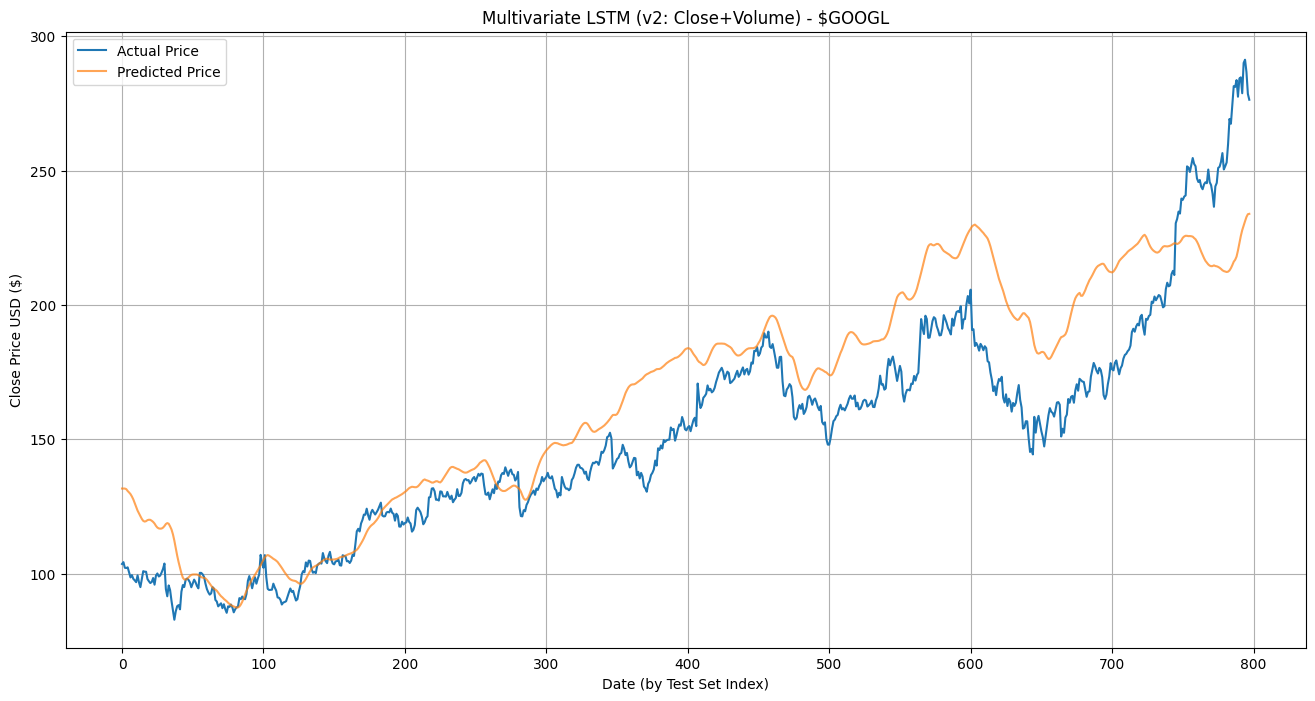

In [4]:
# === 1. LOAD DATA ===
tickers = ['GOOGL', '^IXIC', 'AMZN']
start_date = '2010-01-01'
print("Downloading multivariate data...")
data = yf.download(tickers, start=start_date)

# === 2. CLEAN DATA ===

# Change 1: We don't just want 'Close'. We want 'Close' AND 'Volume'.]
prices = data[['Close', 'Volume']].copy()
prices = prices.dropna()

# === 3. SCALE & PREPARE "WINDOWS" ===

# 3.1 - Scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

# 3.2 - Windowing
lookback_period = 60
training_data_len = int(np.ceil(len(scaled_data) * .8))

train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - lookback_period:, :]

X_train = []
y_train = []
print("Building training 'flashcards'...")
for i in range(lookback_period, len(train_data)):
    X_train.append(train_data[i - lookback_period:i, :])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
# Change 2: This line now needs to get the 'GOOGL' 'Close' price, not just 'GOOGL'.]

y_test = prices['Close']['GOOGL'][training_data_len:].values

print("Building test 'flashcards'...")
for i in range(lookback_period, len(test_data)):
    X_test.append(test_data[i-lookback_period:i, :])
X_test = np.array(X_test)

# Change 3: Our data is no longer 3 features. It's 6. (Close+Volume for 3 tickers
# How will you change these lines?
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

# === 4. BUILD & TRAIN MODEL ===

print("multivariate LTSM model being built")
model = Sequential()

# [Change 3 (Again): The model's input_shape is also now 6 features, not 3.]
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 6)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=10)

# === 5. EVALUATE & PLOT ===
print("Making predictions...")
predictions = model.predict(X_test)

# Chage 4: Our dummy array now needs to have 6 columns, not 3.]
dummy_array = np.zeros((len(predictions), 6))
dummy_array[:, 0] = predictions.flatten()
unscaled_data = scaler.inverse_transform(dummy_array)
unscaled_predictions = unscaled_data[:, 0]

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, unscaled_predictions))
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")

# Plot
# (This part of the code doesn't need to change at all)
plot_df = pd.DataFrame({
    'Actual' : y_test.flatten(),
    'Predicted' : unscaled_predictions.flatten()
})
plt.figure(figsize=(16, 8))
plt.title('Multivariate LSTM (v2: Close+Volume) - $GOOGL')
plt.xlabel('Date (by Test Set Index)')
plt.ylabel('Close Price USD ($)')
plt.plot(plot_df['Actual'], label='Actual Price')
plt.plot(plot_df['Predicted'], label='Predicted Price', alpha=0.7)
plt.legend()
plt.grid()
plt.show()